<a href="https://colab.research.google.com/github/Ellen-Gu/Quantitative-Analysis/blob/main/Exploring_and_Advancing_in_AI_(part_2)_A_Journey_with_tensorflow%2C_pytorch%2C_LLMs%2C_Quantized_Models_and_APP_development%2C_and_Continuous_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#### 12/06/2023 update: Successfully resolved the Langchain issue. GPU acceleration is now fully operational in Langchain

After extensive research and adjustments, I've successfully enabled GPU acceleration in Langchain on my new laptop equipped with an NVIDIA GeForce 4090 GPU. Initially, both my older laptop with a Quadro M1200 GPU and the new one faced issues. While the GPUs were recognized by llam.cpp, TensorFlow, PyTorch, and Docker, Langchain encountered errors during prompt responses, indicating a lack of compatible GPU acceleration.

The breakthrough came from a suggestion about version alignment. It turned out that the CUDA version in my Docker environment (12.3) didn't match the host system's version (12.2). Resolving this inconsistency was key. I chose to upgrade the CUDA version on the host system, ensuring compatibility with the Docker environment. This alignment led to successful GPU acceleration in Langchain and other packages after a system reboot.

However, the same adjustments on my older laptop didn't yield the same results. Langchain, which initially released in October 2022 and stabilized in November 2023, may not support older GPU models. Additionally, my older laptop is confined to Windows 10, unable to upgrade to Windows 11, and there are known issues with WSL on Windows 10 regarding GPU version recognition. A clean installation might offer further insights, but for now, my focus has shifted to other projects, leaving the older system as is.

#### End of 12/06/2023 update


In [ ]:
# original contents start from here

The gguf (converted and quantized) download from huggieface may ran into errors when trying to accelerating with GPU. This may related to some cpmpatible issues with windows system/WSL.  However, I think if llama.cpp can re-compile, make and quantize locally then we may bypass the issue and gain more advantage to quantize other llama type models.

I encounter this issue with llam.cpp, even though nvidia card is working perfectly with tensorflow and pytorch locally on my laptop. Today I read a shortcut on Oreilly. It leads through how to use llama.cpp to re-compile, make and quantizeand with GPU acceleration. I decide to give it a try. After some twick it works! Now I can shift 32 layers out of 35 layers of 7b model to GPU. I wonder that the quantized model download from huggieface may contain some more trainings. But the style of locally re-compiled and quantized model seems more fit in my expectations.

The git rep are at https://github.com/facebookresearch/llama and https://github.com/ggerganov/llama.cpp.git. After downloading the git rep one can run as instarcted the ./downloas.sh . If in the middle of downloading there are some internet interupts, just rerun this sh, it will automatically continue from the place where the internt is interupted.

After get all llama model files and the git rep, the first step is check whether the nvidia card works, and whether cuda toolkit is installed properly. For my current laptop (more than five years old), the GPU card and nvcc version details are as below:


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Sep__8_19:17:24_PDT_2023
Cuda compilation tools, release 12.3, V12.3.52
Build cuda_12.3.r12.3/compiler.33281558_0


In [ ]:
!nvidia-smi

Tue Nov 28 03:49:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.01             Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro M1200                   On  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8              N/A / 200W |      0MiB /  4096MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

After verifing the nvcc version and nvidia-smi, which is expected to work normally, we can add the cuda home path, make a 7B subfolder inside the ./llama folder, and most of all, change the vocab count in the params.json file in the folder downloaded from facebook. This will make the re-compile/make/quantize error free. Other parts from Oreilly shortcut are working fine. I do not fully follow the instruction on the git rep from facebook, instead I generally follow the steps on Oreilly shortcut, and it works well after twick and correct as below.

In [ ]:
export CUDA_HOME=/usr/local/cuda-12.3
mkdir models/7B
nano ../llama/llama-2-7b-chat/params.json   # change vocab from -1 to 32000
# the only errors I encounter with oreilly shortcut codes for recompile and cquantize with llama.cpp are above,
# the vocab para in llama.cpp folder needs to be changed to 32000, which I think are the vocab count in 7b model.
# usually 5k vocab is ok for normal chat, 30k is good enough, 50k is more than enough, 100k is language experts which is rare in daily activities.


After all settled, the quantized 7b works directly in terminal. The model details are as below.

In [ ]:
!cd /home/sharedspace/gguf-cpp/llama.cpp && \
 ./main -m ./models/7B/ggml-model-q4_0.gguf -n 1024 --repeat_penalty 1.0 --color -i -r "User:" -f ./prompts/chat-with-bob.txt --n-gpu-layers 32

Log start
main: build = 1571 (bb03290)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: seed  = 1701144246
ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: Quadro M1200, compute capability 5.0
llama_model_loader: loaded meta data with 16 key-value pairs and 291 tensors from ./models/7B/ggml-model-q4_0.gguf (version GGUF V3 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q4_0     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:               output_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:                    output.weight q6_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_q.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.attn_k.weight q4_0     [  4096,  4096,     1,     1

From the outputs above we can see that 32 out of 35 layers of 7b model are now shifted to GPU for computing. I tryied 35 (default is 1000) but my GPU has only 4GB RAM hence only can hold 32 layers. I am very happy to see that finally the local quantized 7b model works with GPU support.

I asked the same questions as in last time. Apparently, "Bob", the chat agent from the locally re-compile and quantized llama 7b model seems giving more preferrable responses. The followings are screenshot of chat between Bob and me, The yellow part is from the llama cpp git rep samples. Aside the "Bob" , there are some other sample prompt initialize files:

In [ ]:
!ls -l /home/sharedspace/gguf-cpp/llama.cpp/prompts

total 56
-rwxrwsr-- 1 root sharedspace  106 Nov 27 15:06 alpaca.txt
-rwxrwsr-- 1 root sharedspace 2348 Nov 27 15:06 assistant.txt
-rwxrwsr-- 1 root sharedspace 1837 Nov 27 15:06 chat.txt
-rwxrwsr-- 1 root sharedspace   90 Nov 27 15:06 chat-with-baichuan.txt
-rwxrwsr-- 1 root sharedspace  386 Nov 27 15:06 chat-with-bob.txt
-rwxrwsr-- 1 root sharedspace  446 Nov 27 15:06 chat-with-vicuna-v0.txt
-rwxrwsr-- 1 root sharedspace  426 Nov 27 15:06 chat-with-vicuna-v1.txt
-rwxrwsr-- 1 root sharedspace 1538 Nov 27 15:06 dan-modified.txt
-rwxrwsr-- 1 root sharedspace 1663 Nov 27 15:06 dan.txt
-rwxrwsr-- 1 root sharedspace 2598 Nov 27 15:06 LLM-questions.txt
-rwxrwsr-- 1 root sharedspace 5086 Nov 27 15:06 mnemonics.txt
-rwxrwsr-- 1 root sharedspace 1716 Nov 27 15:06 parallel-questions.txt
-rwxrwsr-- 1 root sharedspace  758 Nov 27 15:06 reason-act.txt


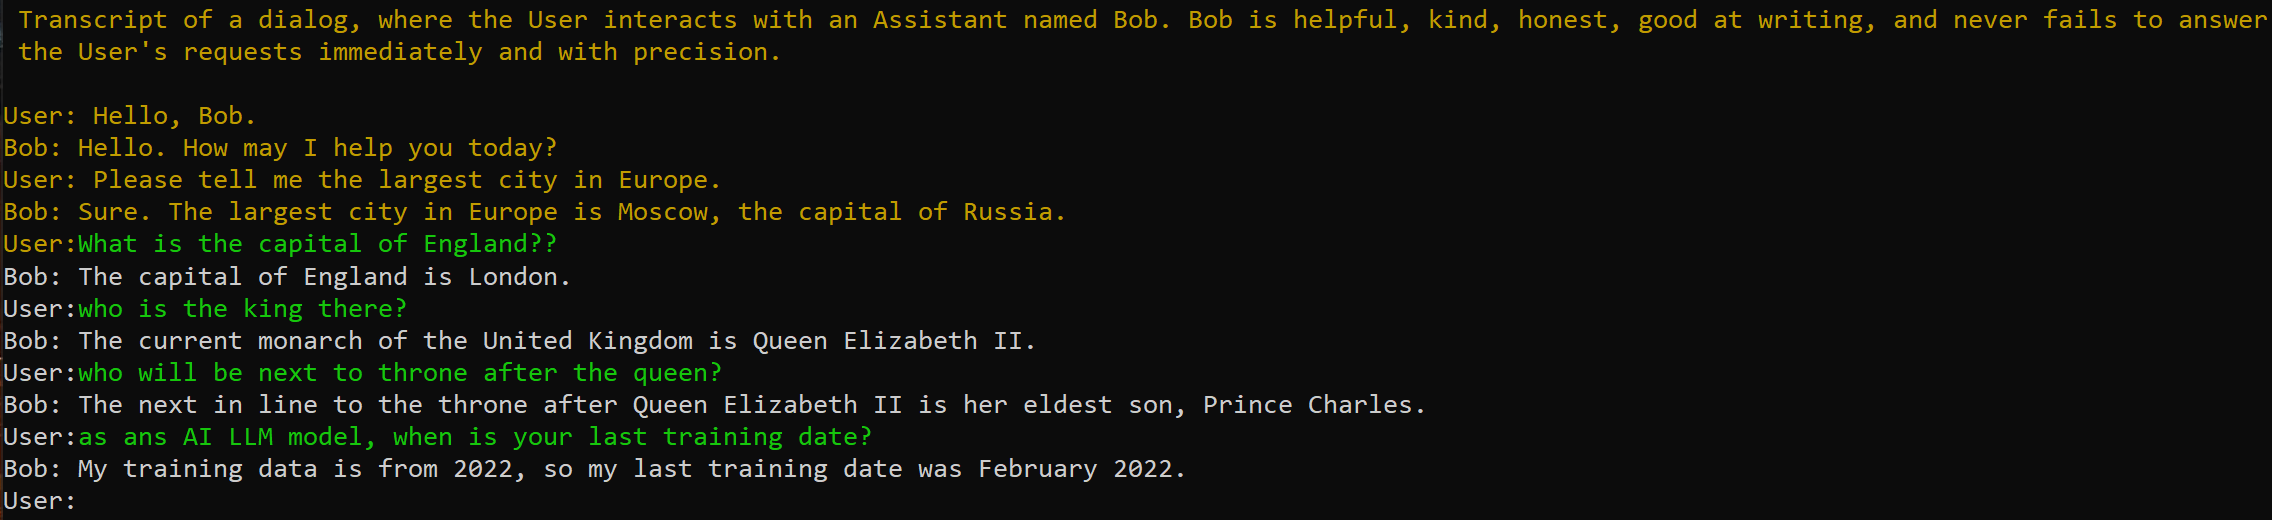

In [ ]:
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/Colab Notebooks/quantize-7bmodel-4bit.png",width=1000))

The recompiled and quantized 7b model works well on terminal. However, I still have some issue when trying to use GPU accelerating with LangChain. It looks like the window/wsl issue is at least also influenced LangChain. Maybe this will be ok with upgraded to win 11 as per some users opinons. Another issue with LangChain and locally quantized model is that for CPU usage, it seems not be able to answer as accuratly as models downladed from huggieface. I think the locally re-compiled and quantized model in the terminal gives the best answers. The followings are LangChain prompt/answer of the same set of question. It looks that this time instead of ignore the word King/Queen, it gets confused and give a non-relevent answer, as its last training is in Feb 2022.

In [ ]:
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, AutoModelForSeq2SeqLM
from langchain.llms import LlamaCpp
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

n_gpu_layers = 0  # Change this value based on your model and your GPU VRAM pool: Set to 0 to use GPU syntax but run on CPU
n_batch = 32  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.

# Callbacks support token-wise streaming
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

# Make sure the model path is correct!
llm = LlamaCpp(
    model_path="/home/sharedspace/gguf-cpp/llama.cpp/models/7B/ggml-model-q4_0.gguf",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    temperature=0,  # want answers not so randomly
    callback_manager=callback_manager,
    verbose=True,  # Verbose is required to pass to the callback manager
    max_tokens=1000 # adjusted from 256 (Default) to get more complete answers
)

llama_model_loader: loaded meta data with 16 key-value pairs and 291 tensors from /home/sharedspace/gguf-cpp/llama.cpp/models/7B/ggml-model-q4_0.gguf (version GGUF V3 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q4_0     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:               output_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:                    output.weight q6_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_q.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.attn_k.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:              blk.0.attn_v.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    6:         blk.0.attn_output.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:            blk.0.ffn_gate.weight

In [ ]:
prompt = """
Question: What is the capital of England??
"""
llm(prompt)



Answer: London is the capital of England.


llama_print_timings:        load time =    2100.48 ms
llama_print_timings:      sample time =       4.67 ms /    11 runs   (    0.42 ms per token,  2353.44 tokens per second)
llama_print_timings: prompt eval time =    2100.00 ms /    12 tokens (  175.00 ms per token,     5.71 tokens per second)
llama_print_timings:        eval time =    2662.55 ms /    10 runs   (  266.26 ms per token,     3.76 tokens per second)
llama_print_timings:       total time =    4816.79 ms


'\nAnswer: London is the capital of England.'

In [ ]:
prompt = """
Question: who is the king there?
"""
llm(prompt)

Llama.generate: prefix-match hit



Answer: The King of Thailand is currently Maha Vajiralongkorn Bodindradebayavarangsi, also known as King Rama X. He ascended to the throne in 2016 upon the death of his father, King Bhumibol Adulyadej.


llama_print_timings:        load time =    2100.48 ms
llama_print_timings:      sample time =      29.52 ms /    65 runs   (    0.45 ms per token,  2202.27 tokens per second)
llama_print_timings: prompt eval time =    1256.40 ms /     7 tokens (  179.49 ms per token,     5.57 tokens per second)
llama_print_timings:        eval time =   16659.00 ms /    64 runs   (  260.30 ms per token,     3.84 tokens per second)
llama_print_timings:       total time =   18239.12 ms


'\nAnswer: The King of Thailand is currently Maha Vajiralongkorn Bodindradebayavarangsi, also known as King Rama X. He ascended to the throne in 2016 upon the death of his father, King Bhumibol Adulyadej.'

In [ ]:
prompt = """
Question: who will be next to throne after the queen?
"""
llm(prompt)

Llama.generate: prefix-match hit



The current line of succession to the British throne is as follows:

1. Queen Elizabeth II
2. Prince Charles, Prince of Wales (her eldest son)
3. Prince William, Duke of Cambridge (her grandson and Prince Charles's eldest son)
4. Prince George of Cambridge (Prince William and Catherine Middleton's eldest son)
5. Princess Charlotte of Cambridge (Prince William and Catherine Middleton's second child and only daughter)
6. Prince Louis of Cambridge (Prince William and Catherine Middleton's third child and second son)
7. Prince Andrew, Duke of York (Queen Elizabeth II's second son)
8. Princess Beatrice of York (Prince Andrew's eldest daughter)
9. Princess Eugenie of York (Prince Andrew's youngest daughter)
10. Viscount Severn (Princess Anne's elder son)

So, after Queen Elizabeth II, the next in line to the throne would be Prince Charles, followed by his sons and then his grandchildren.


llama_print_timings:        load time =    2100.48 ms
llama_print_timings:      sample time =      99.09 ms /   230 runs   (    0.43 ms per token,  2321.12 tokens per second)
llama_print_timings: prompt eval time =    1833.04 ms /    10 tokens (  183.30 ms per token,     5.46 tokens per second)
llama_print_timings:        eval time =   62967.33 ms /   229 runs   (  274.97 ms per token,     3.64 tokens per second)
llama_print_timings:       total time =   66012.17 ms


"\nThe current line of succession to the British throne is as follows:\n\n1. Queen Elizabeth II\n2. Prince Charles, Prince of Wales (her eldest son)\n3. Prince William, Duke of Cambridge (her grandson and Prince Charles's eldest son)\n4. Prince George of Cambridge (Prince William and Catherine Middleton's eldest son)\n5. Princess Charlotte of Cambridge (Prince William and Catherine Middleton's second child and only daughter)\n6. Prince Louis of Cambridge (Prince William and Catherine Middleton's third child and second son)\n7. Prince Andrew, Duke of York (Queen Elizabeth II's second son)\n8. Princess Beatrice of York (Prince Andrew's eldest daughter)\n9. Princess Eugenie of York (Prince Andrew's youngest daughter)\n10. Viscount Severn (Princess Anne's elder son)\n\nSo, after Queen Elizabeth II, the next in line to the throne would be Prince Charles, followed by his sons and then his grandchildren."

In [ ]:
prompt = """
Question: as ans AI LLM model, when is your last training date?
"""
llm(prompt)

Llama.generate: prefix-match hit


 nobody knows the answer to that question.

Because I'm just an AI assistant trained by Meta AI, I don't have a specific "last training date" in the classical sense. My training process is ongoing and continuous, as I learn from a vast corpus of text data and improve my language models over time.
My training data includes a wide range of texts, including books, articles, and websites, which are constantly being updated and expanded to keep my knowledge up-to-date. This means that my understanding of language and my ability to generate responses are always evolving and improving.
So, while I can't provide you with an exact date for when I was "last trained," I can assure you that I am constantly learning and adapting to improve my language abilities.


llama_print_timings:        load time =    2100.48 ms
llama_print_timings:      sample time =      79.86 ms /   171 runs   (    0.47 ms per token,  2141.33 tokens per second)
llama_print_timings: prompt eval time =    2898.41 ms /    16 tokens (  181.15 ms per token,     5.52 tokens per second)
llama_print_timings:        eval time =   44636.88 ms /   170 runs   (  262.57 ms per token,     3.81 tokens per second)
llama_print_timings:       total time =   48404.08 ms


' nobody knows the answer to that question.\n\nBecause I\'m just an AI assistant trained by Meta AI, I don\'t have a specific "last training date" in the classical sense. My training process is ongoing and continuous, as I learn from a vast corpus of text data and improve my language models over time.\nMy training data includes a wide range of texts, including books, articles, and websites, which are constantly being updated and expanded to keep my knowledge up-to-date. This means that my understanding of language and my ability to generate responses are always evolving and improving.\nSo, while I can\'t provide you with an exact date for when I was "last trained," I can assure you that I am constantly learning and adapting to improve my language abilities.'